In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [2]:
file = r"C:\Users\zacwa\bike_sharing_daily.csv"
bikes = pd.read_csv(file,sep=',')
bikes['dteday'] = pd.to_datetime(bikes.dteday,format='%Y-%m-%d')
bikes.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


data \
https://www.kaggle.com/datasets/contactprad/bike-share-daily-data?resource=download

The below visualizations indicate that there could be outliers. I'll explore that possibility with a handful of methods.

The data's coding of seasons doesn't appear to make sense. Fall temps shouldn't be that much higher than summer. But I'll ignore that for the sake of this exercise and assume the data was generated and coded accurately.

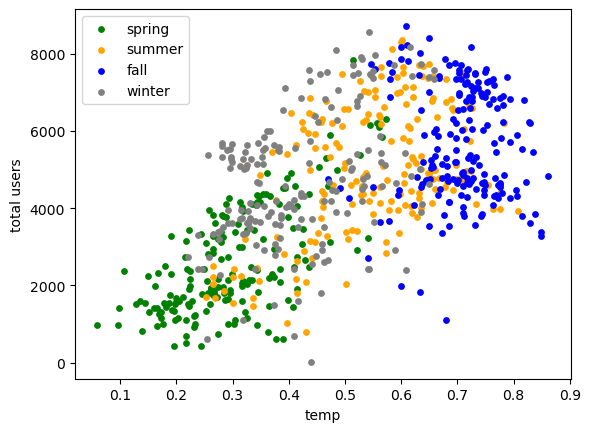

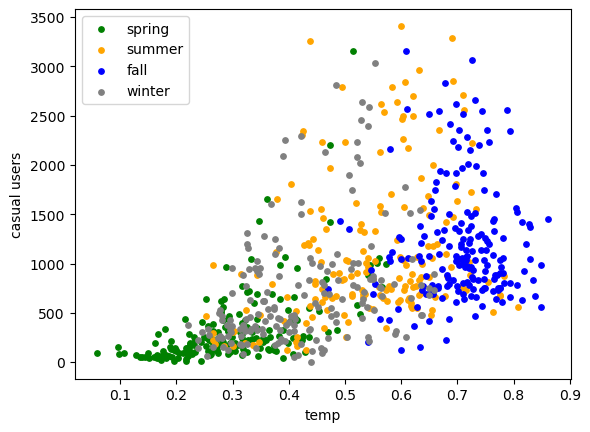

In [3]:
season_code = bikes.season.unique().tolist()
season_code.sort()
seasons = ['spring','summer','fall','winter']
cs = ['green','orange','blue','gray']
def usertemp(bikes):
    for sc, s, c in zip(season_code,seasons,cs):
        temp = bikes.loc[bikes.season==sc,'temp'].copy()
        tusers = bikes.loc[bikes.season==sc,'cnt'].copy()
        plt.scatter(temp,tusers,c=c,label=s,s=15)
    plt.xlabel('temp')
    plt.ylabel('total users')
    plt.legend()
    plt.show()

    for sc, s, c in zip(season_code,seasons,cs):
        temp = bikes.loc[bikes.season==sc,'temp'].copy()
        tusers = bikes.loc[bikes.season==sc,'casual'].copy()
        plt.scatter(temp,tusers,c=c,label=s,s=15)
    plt.xlabel('temp')
    plt.ylabel('casual users')
    plt.legend()
    plt.show()

usertemp(bikes)

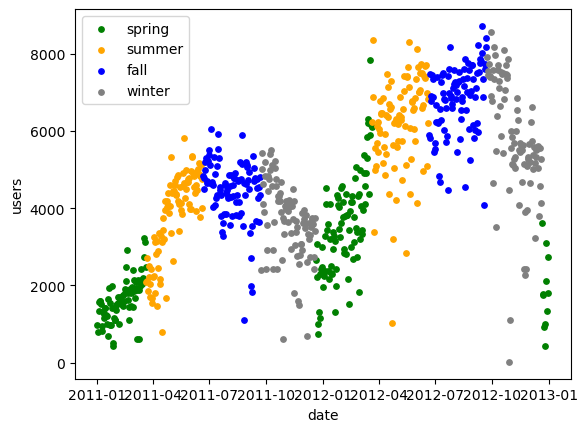

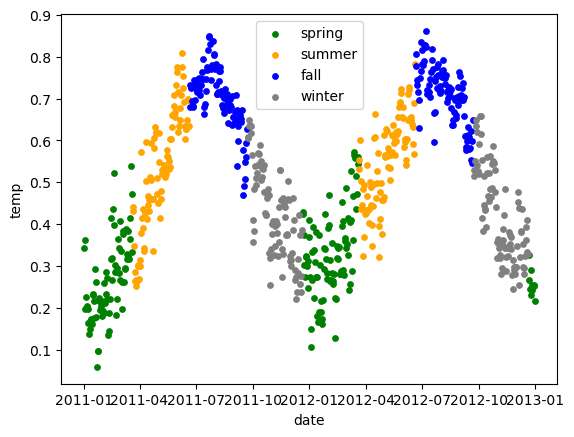

In [4]:
def usertempseries(bikes):
    for sc, s, c in zip(season_code,seasons,cs):
        day = bikes.loc[bikes.season==sc, 'dteday'].copy()
        cnt = bikes.loc[bikes.season==sc, 'cnt'].copy()
        plt.scatter(day,cnt,c=c,label=s,s=15)
    plt.legend()
    plt.xlabel('date')
    plt.ylabel('users')
    plt.show()

    for sc, s, c in zip(season_code,seasons,cs):
        day = bikes.loc[bikes.season==sc, 'dteday'].copy()
        temp = bikes.loc[bikes.season==sc, 'temp'].copy()
        plt.scatter(day,temp,c=c,label=s,s=15)
    plt.legend()
    plt.xlabel('date')
    plt.ylabel('temp')
    plt.show()

usertempseries(bikes)

### Outlier Detection

In [5]:
quant_vars = ['temp', 'atemp', 'hum', 'windspeed','casual', 'registered', 'cnt']
bq = bikes[quant_vars]
all_vars = ['season', 'yr', 'mnth', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt']
ba = bikes[all_vars] # minus date

#### Simple method of Z-Scores

We're looking only at the quantitative variables.

In [6]:
def z_scores(X):
    n = X.shape[0]
    X = X.to_numpy().reshape(n,-1)
    scaler = StandardScaler(with_mean=True,with_std=True)
    return scaler.fit_transform(X)

def is_outlier(X):
    n = X.shape[0]
    outlier = [False]*n
    for i in range(n):
        # I'm calling an outlier whatever is > 3 stds
        if abs(X[i]) > 3:
            outlier[i] = True
    return outlier

In [7]:
bz = bikes.copy()
has_outliers = {}
for v in quant_vars:
    scores = z_scores(bz[v])
    bz[v+'_z'] = scores
    outs = is_outlier(bz[v+'_z'])
    bz[v+'_is_o'] = outs
    name = v+'_is_o'
    print(f'there are { bz[name].sum() } outliers in the {v} variable')
    if bz[name].sum() > 0:
        has_outliers[v] = bz[name].sum()

there are 0 outliers in the temp variable
there are 0 outliers in the atemp variable
there are 2 outliers in the hum variable
there are 2 outliers in the windspeed variable
there are 8 outliers in the casual variable
there are 0 outliers in the registered variable
there are 0 outliers in the cnt variable


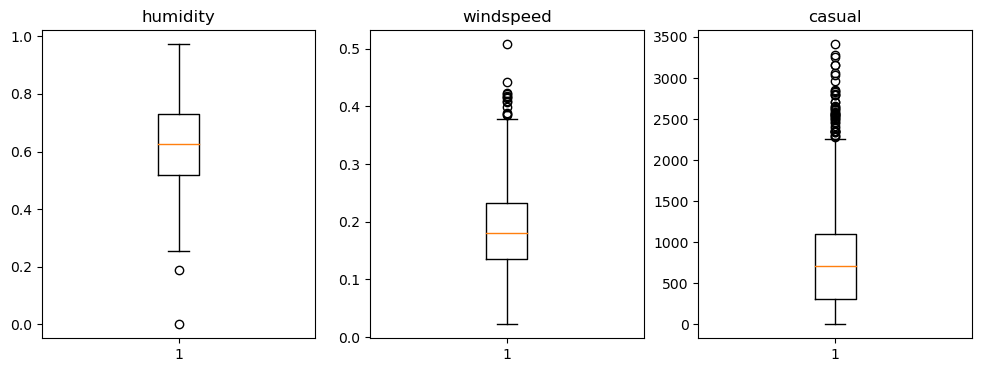

In [8]:
fig, axs = plt.subplots(1,3,figsize=(12,4))
axs = axs.flatten()
axs[0].boxplot(bz.hum)
axs[0].set_title('humidity')
axs[1].boxplot(bz.windspeed)
axs[1].set_title('windspeed')
axs[2].boxplot(bz.casual)
axs[2].set_title('casual')
plt.show()

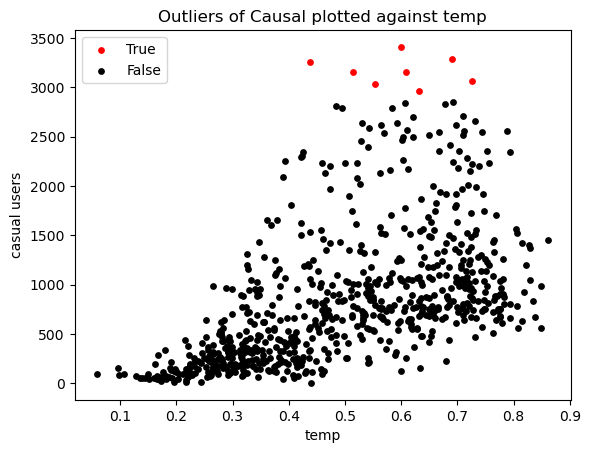

In [9]:
outlier = bz.casual_is_o
for o in [True,False]:
    c = 'red' if o else 'black'
    temp = bz.loc[bz.casual_is_o==o,'temp'].copy()
    casuals = bz.loc[bz.casual_is_o==o,'casual'].copy()
    plt.scatter(temp,casuals,c=c,label=o,s=15)
plt.xlabel('temp')
plt.ylabel('casual users')
plt.title('Outliers of Causal plotted against temp')
plt.legend(loc='upper left')
plt.show()

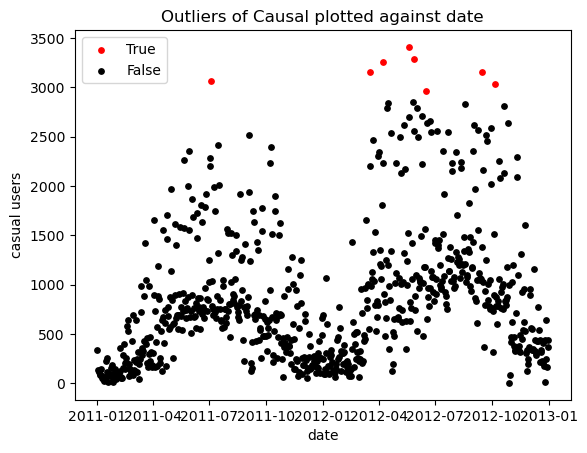

In [10]:
outlier = bz.casual_is_o
for o in [True,False]:
    c = 'red' if o else 'black'
    dts = bz.loc[bz.casual_is_o==o,'dteday'].copy()
    casuals = bz.loc[bz.casual_is_o==o,'casual'].copy()
    plt.scatter(dts,casuals,c=c,label=o,s=15)
plt.xlabel('date')
plt.ylabel('casual users')
plt.title('Outliers of Causal plotted against date')
plt.legend(loc='upper left')
plt.show()

If I wanted to explore this further I would repeat this z-score process but with different buckets: weekdays, seasons, years, months, etc. and plot.

#### Using KMeans, distance from centroid on top 3 principle components

I'm using all the variables minus date.

I'll use 3 PCs because I want to visualize things in 3D. It would be good to select by variance accounted for but that may yield dimensions that cannot be visualized. I really want to view 3D visuals for this particular exercise. So, I'll assume from the start the n_comps = 3 explains an acceptably high amount of variance.

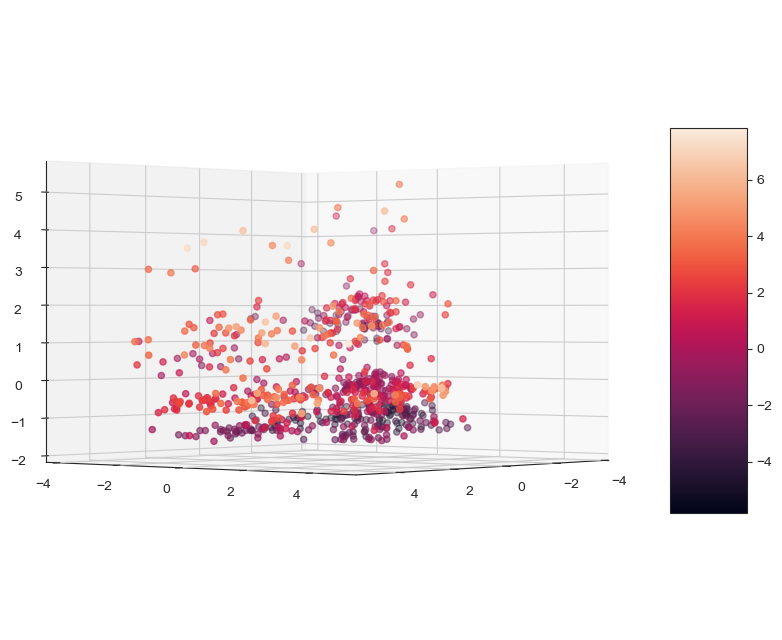

In [21]:
bqz = z_scores(ba)
bco = PCA(n_components=3).fit_transform(bqz)
bcodf = pd.DataFrame(bco).rename(columns={0:'pc1',1:'pc2',2:'pc3'})

sb.set_style('white')
plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
sctt = ax.scatter3D(bcodf.pc1,bcodf.pc2,bcodf.pc3,c=(bcodf.pc1+bcodf.pc2+bcodf.pc3))
fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5)
ax.azim = 40
ax.elev = 0
ax.roll = 0
plt.show()

Determine and choose clusters centers....

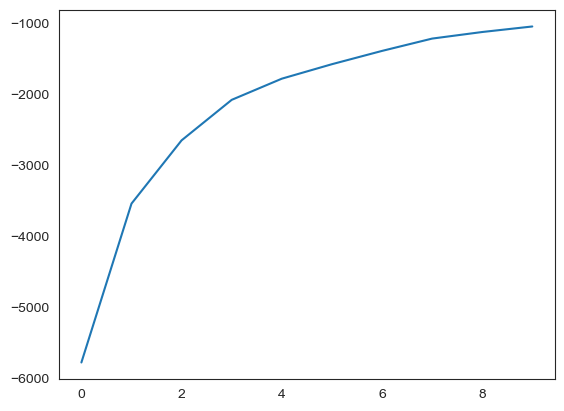

In [12]:
def km(X,i):
    return KMeans(n_clusters=i,n_init=10).fit(X)
def scoreKM(X,km):
    return km.score(X)


kmodels = [km(bcodf,i) for i in range(1,11)]
kscores = [scoreKM(bcodf,km) for km in kmodels]
plt.plot(kscores)

In [13]:
chosen_n_clusters_ind = 3
chosen_km = kmodels[chosen_n_clusters_ind]
cluster_labels = chosen_km.labels_
bcodf['clusters'] = cluster_labels

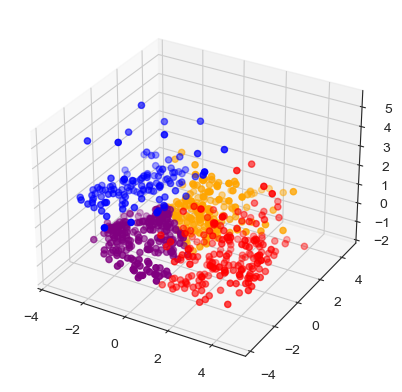

In [14]:
# visualize the clusters
cs = ['red','blue','orange','purple']
ax = plt.axes(projection='3d')
for i in range(chosen_n_clusters_ind+1):
    b_temp = bcodf.loc[bcodf.clusters==i].copy()
    ax.scatter(b_temp.pc1,b_temp.pc2,b_temp.pc3,c=cs[i],label=i)

Compute distances from each centroid

In [15]:
for clst in range(chosen_n_clusters_ind+1):
    idx = (bcodf.clusters==clst)
    cntr = chosen_km.cluster_centers_[clst]
    bcodf.loc[idx,'dist'] = np.linalg.norm(bcodf.loc[idx,['pc1','pc2','pc3']]-cntr,axis=1)

In [16]:
bcodf

,pc1,pc2,pc3,clusters,dist
0,3.426056,0.711077,1.273294,0,2.177017
1,3.793771,0.228229,1.434721,0,2.159704
2,4.042404,-1.562175,-0.446183,0,1.596774
3,3.673728,-0.781567,-0.456968,0,1.054818
4,3.619645,-1.438197,-0.590596,0,1.234585
...,...,...,...,...,...
726,2.706385,0.393798,-1.056201,0,1.530460
727,1.668030,0.435193,-0.971780,0,1.820359
728,2.608888,1.254222,0.570306,0,2.165274
729,2.670096,-1.198563,0.850991,0,1.032220


Determining outliers according to "significant" distance from the centroid... I'll use a slightly more generous boundary abs(3*STD). I would prefer this for the sake of segment analysis which would be performed following cluster outlier id.

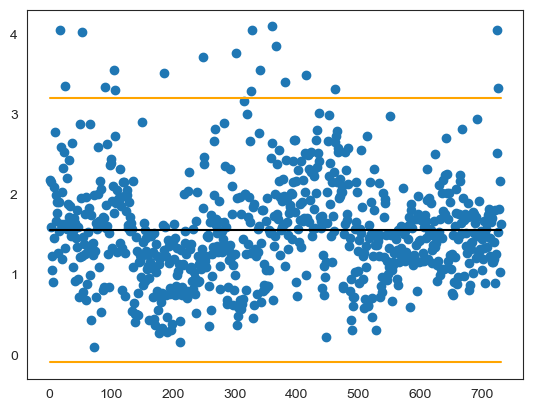

In [17]:
mn = bcodf.dist.mean()
sd = bcodf.dist.std()
plt.scatter(np.linspace(1,731,731),bcodf.dist)
plt.plot(np.linspace(1,731,731),[mn]*731,c='black')
plt.plot(np.linspace(1,731,731),[2.5*sd+mn]*731,c='orange')
plt.plot(np.linspace(1,731,731),[-2.5*sd+mn]*731,c='orange')
plt.show()

# z_dist = z_scores(bcodf.dist)
idx_o = (bcodf.dist > 2.5*sd+mn) | (bcodf.dist < -2.5*sd+mn)
bcodf.loc[idx_o,'outlier_dist'] = True
bcodf.loc[~idx_o,'outlier_dist'] = False

In [18]:
bcodf.loc[idx_o,:]

,pc1,pc2,pc3,clusters,dist,outlier_dist
16,4.568978,-0.629511,3.477636,0,4.051131,True
25,4.893568,1.685290,-0.428336,0,3.345717,True
51,4.124409,-0.501428,3.633166,0,4.016064,True
89,3.483974,2.484777,-0.521863,2,3.330762,True
104,1.507674,-0.622468,3.598978,1,3.548579,True
105,3.371201,2.172489,1.150413,0,3.301198,True
184,-2.075700,0.461330,5.321101,1,3.506377,True
247,-0.004567,1.669167,4.511529,1,3.715378,True
301,3.453352,3.398012,1.010107,2,3.756357,True
325,1.629256,4.713604,-0.126125,2,3.286169,True


The visualizations used in the basic method are observed and adjusted so clusters can be distinguished. The placement of some of these outliers suggests that the variance that explains them occurs over more than two dimensions.

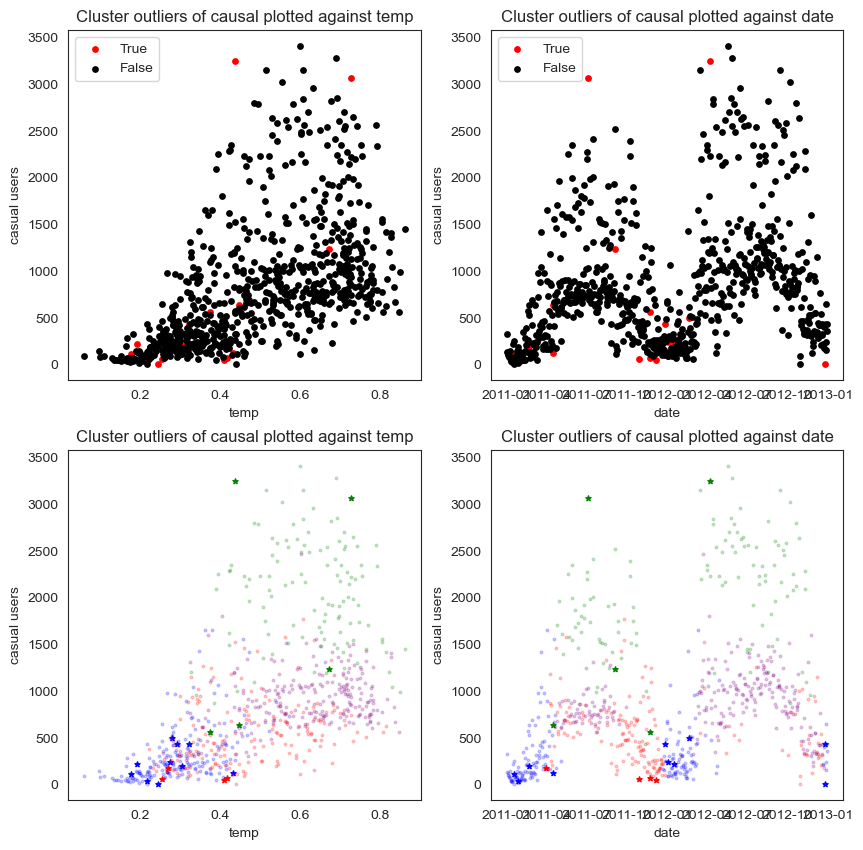

In [19]:
bz2 = bz.join(bcodf)
outlier = bcodf.outlier_dist
fig, axs = plt.subplots(2,2,figsize=(10,10))
axs = axs.flatten()
for o in [True,False]:
    c = 'red' if o else 'black'
    temp = bz2.loc[bz2.outlier_dist==o,'temp'].copy()
    casuals = bz2.loc[bz2.outlier_dist==o,'casual'].copy()
    axs[0].scatter(temp,casuals,c=c,label=o,s=15)
axs[0].set_xlabel('temp')
axs[0].set_ylabel('casual users')
axs[0].set_title('Cluster outliers of causal plotted against temp')
axs[0].legend(loc='upper left')

for o in [True,False]:
    c = 'red' if o else 'black'
    dts = bz2.loc[bz2.outlier_dist==o,'dteday'].copy()
    casuals = bz2.loc[bz2.outlier_dist==o,'casual'].copy()
    axs[1].scatter(dts,casuals,c=c,label=o,s=15)
axs[1].set_xlabel('date')
axs[1].set_ylabel('casual users')
axs[1].set_title('Cluster outliers of causal plotted against date')
axs[1].legend(loc='upper left')

for cl, co in zip(bcodf.clusters.unique(),['blue','red','green','purple']):
    cl_temp = bz2.loc[bz2.clusters==cl].copy()
    for o in [True,False]:
        c_ = 0.95 if o else 0.2
        m_ = '*' if o else '.'
        temp = cl_temp.loc[cl_temp.outlier_dist==o,'temp'].copy()
        casuals = cl_temp.loc[cl_temp.outlier_dist==o,'casual'].copy()
        axs[2].scatter(temp,casuals,c=co,alpha=c_,marker=m_,label=m_,s=15)
axs[2].set_xlabel('temp')
axs[2].set_ylabel('casual users')
axs[2].set_title('Cluster outliers of causal plotted against temp')

for cl, co in zip(bcodf.clusters.unique(),['blue','red','green','purple']):
    cl_temp = bz2.loc[bz2.clusters==cl].copy()
    for o in [True,False]:
        c_ = 0.95 if o else 0.2
        m_ = '*' if o else '.'
        date = cl_temp.loc[cl_temp.outlier_dist==o,'dteday'].copy()
        casuals = cl_temp.loc[cl_temp.outlier_dist==o,'casual'].copy()
        axs[3].scatter(date,casuals,c=co,alpha=c_,marker=m_,label=m_,s=15)
axs[3].set_xlabel('date')
axs[3].set_ylabel('casual users')
axs[3].set_title('Cluster outliers of causal plotted against date')

plt.show()

Analysis should be done at the PCA-cluster level.

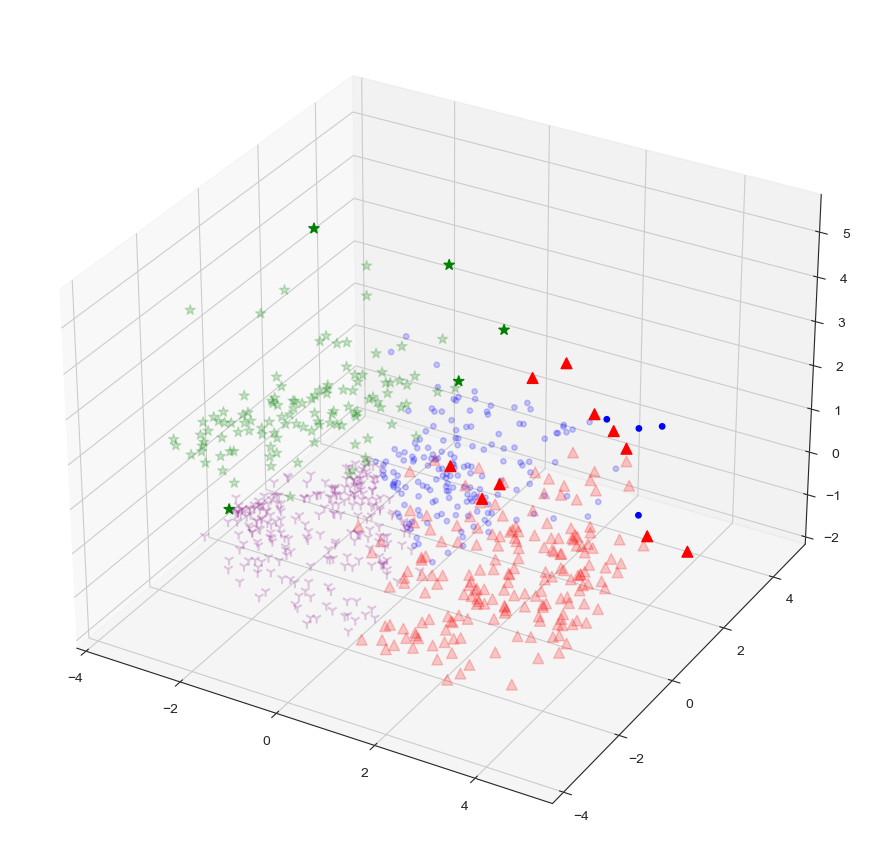

In [20]:
fig = plt.figure()
ax1 = fig.add_subplot(121,projection='3d')
fig.set_figheight(11)
fig.set_figwidth(11)
ax = plt.axes(projection='3d')
# visualize the clusters

cos = ['red','blue','green','purple']
mks = ['^','.','*','1']
cls = bcodf.clusters.unique()
for cl, co, mk in zip(cls,cos,mks):
    c_temp = bcodf.loc[bcodf.clusters==cl].copy()
    for b, a in zip([True,False],[1.0,0.2]):
        b_temp = c_temp.loc[c_temp.outlier_dist==b].copy()
        ax.scatter(b_temp.pc1,b_temp.pc2,b_temp.pc3,c=co,alpha=a,marker=mk,label=b,s=60)


At this point, I'd start doing some EDA on each cluster to understand what makes them different. I'd also consider more closely the outliers resulting from both methods.